<a href="https://colab.research.google.com/github/walexi/class-mini-project-5/blob/main/GANs_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


Data source import complete.


## Imports

In [ ]:
!pip install -U torch torchvision 'torch_xla[tpu]'

In [ ]:
!pip install optuna-dashboard plotly nbformat optuna jdc munch omegaconf wandb[media]

In [ ]:
!pip install lightning

In [ ]:
import numpy as np
from numpy.typing import NDArray
from typing import List, Any, Tuple, Dict
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

from IPython import display

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from lightning.pytorch.loggers import WandbLogger
import lightning.pytorch as pl
from mpl_toolkits.axes_grid1 import ImageGrid
from math import ceil
import wandb
import gc
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances
from munch import DefaultMunch, munchify
import logging
import sys
from omegaconf import OmegaConf
from tqdm import tqdm
from datetime import datetime
import random
import json
import glob
import time
import itertools

import jdc
%matplotlib inline

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
from google.colab import userdata
key = userdata.get('wandb_key')

In [ ]:
!wandb login $key

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(project='gan')

wandb: Currently logged in as: walexi to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
logger = WandbLogger(project="gan", offline=True, save_dir="/content/")

## Project Topic: **GAN Mini-Project**

This aim of this project is to train a generative model to generate images that

In [ ]:
WRK_DIR = gan_getting_started_path
MONET_DIR = f"{WRK_DIR}/monet_jpg"
PHOTO_DIR = f"{WRK_DIR}/photo_jpg/"

In [ ]:
BATCH_SIZE = 16
img_height = 256
img_width = 256
MAX_EPOCHS = 3
NUM_WORKERS= 3

In [ ]:
MONET_FILENAMES = glob.glob(os.path.join(MONET_DIR, '*.jpg'))
PHOTO_FILENAMES = glob.glob(os.path.join(PHOTO_DIR, '*.jpg'))

In [ ]:
MONET_FILENAMES[0]

'/root/.cache/kagglehub/competitions/gan-getting-started/monet_jpg/ee7adac58f.jpg'

### Trainer

In [ ]:
class GANDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = np.asarray(df[0]), np.asarray(df[1])
        self.transform = transform
        self.dims = (1, img_height, img_width)

    def __len__(self):
        return len(self.df[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x, y = self.df[0][idx], self.df[1][idx]
        x, y = Image.open(x), Image.open(y)
        if self.transform:
            x, y = self.transform(x), self.transform(y)
        return x, y

In [ ]:
class GANDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dfs: Any,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.df = dfs
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
                transforms.Resize(img_width),
                transforms.CenterCrop(img_width),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

        self.dims = (1, img_height, img_width)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            monet_ds = GANDataset(self.df, self.transform)
            self.train_ds, self.val_ds = random_split(monet_ds, [int(0.8 * len(self.df)), int(0.2 * len(self.df))])

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [ ]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int=3, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 × 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

In [ ]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512.

        After the last layer, we apply a convolution to produce a 1-dimensional
        output.

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [ ]:
#from https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        # networks
        # source domain = monet
        # target domain = phot
        self.monet_gen = Generator() # monet => photo
        self.photo_gen = Generator() # photo => monet
        self.monet_dis = Discriminator() #
        self.photo_dis = Discriminator()
        self.gan_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.identity_loss = nn.L1Loss()
        # for m in [self.monet_gen, self.photo_gen, self.monet_dis, self.photo_dis]:
        #     m.apply(weights_init)

In [ ]:
%%add_to GAN
def forward(self, real_monet, real_photo):
    fake_photo = self.monet_gen(real_monet)
    monet = self.photo_gen(fake_photo)
    fake_monet = self.photo_gen(real_photo)
    photo = self.monet_gen(fake_monet)
    return (monet, fake_monet), (photo, fake_photo)

In [ ]:
%%add_to GAN
def configure_optimizers(self):
    params = self.hparams
    lr = params.lr
    b1 = params.b1
    b2 = params.b2

    opt_g = torch.optim.Adam(itertools.chain(self.monet_gen.parameters(), self.photo_gen.parameters()), lr=lr, betas=(b1, b2))
    opt_d = torch.optim.Adam(itertools.chain( self.monet_dis.parameters(), self.photo_dis.parameters()), lr=lr, betas=(b1, b2))
    return [opt_g, opt_d], []

In [ ]:
%%add_to GAN
def backward_dis(self, disc, real, fake):
    # self.toggle_optimizer()
    pred_real = disc(real)
    loss_real = self.gan_loss(pred_real, torch.ones_like(pred_real))
    pred_fake = disc(fake.detach())
    loss_fake = self.gan_loss(pred_fake, torch.zeros_like(pred_fake))
    loss = (loss_real + loss_fake) * 0.5
    return loss

In [ ]:
%%add_to GAN
def forward(self):
    self.fake_photo = self.monet_gen(self.rm)
    self.monet = self.photo_gen(self.fake_photo)
    self.fake_monet = self.photo_gen(self.rp)
    self.photo = self.monet_gen(self.fake_monet)

In [ ]:
%%add_to GAN
def training_step(self, batch):
    real_monet, real_photo = batch
    params = self.hparams
    optimizer_g, optimizer_d = self.optimizers()

    self.rm = real_monet
    self.rp = real_photo

    self.forward()

    self.toggle_optimizer(optimizer_g)
    optimizer_g.zero_grad()

    idt_monet = self.monet_gen(real_photo)
    loss_i_m = self.identity_loss(idt_monet, real_photo) * params.lambda_photo * params.lambda_idt

    idt_p = self.photo_gen(real_monet)
    loss_i_p = self.identity_loss(idt_p, real_photo) * params.lambda_monet * params.lambda_idt
    o1 = self.monet_dis(self.fake_photo)
    loss_m_g = self.gan_loss(o1, torch.ones_like(o1).type_as(o1))
    o2 = self.photo_dis(self.fake_monet)
    loss_p_g = self.gan_loss(o2, torch.ones_like(o2).type_as(o2))

    loss_c_m = self.cycle_loss(self.monet, real_photo) * params.lambda_monet
    loss_c_p = self.cycle_loss(self.photo, real_monet) * params.lambda_photo
    loss_gen = loss_i_m + loss_i_p + loss_m_g + loss_p_g + loss_c_m + loss_c_p
    self.manual_backward(loss_gen)
    optimizer_g.step()
    self.untoggle_optimizer(optimizer_g)

    self.toggle_optimizer(optimizer_d)
    optimizer_d.zero_grad()
    #backward dis monet
    loss_monet_gen = self.backward_dis(self.monet_dis, real_photo, self.fake_photo)
    self.manual_backward(loss_monet_gen)
    # backward dis photo
    loss_photo_dis = self.backward_dis(self.photo_dis, real_monet, self.fake_monet)
    self.manual_backward(loss_photo_dis)
    optimizer_d.step()
    self.untoggle_optimizer(optimizer_d)

    # log sampled images
    m = torch.cat([self.monet, self.fake_monet], axis=0)
    p = torch.cat([self.photo, self.fake_photo], axis=0)
    self.logger.experiment.log({"train/generated_monet": [wandb.Image(m[i]) for i in range(m.shape[0])]})
    self.logger.experiment.log({"train/generated_photo": [wandb.Image(p[i]) for i in range(p.shape[0])]})

In [ ]:
%%add_to GAN
def validation_step(self, batch, batch_idx):
    pass

In [ ]:
%%add_to GAN
def on_validation_epoch_end(self):
    self.forward()
    # log sampled images
    m = torch.cat([self.monet, self.fake_monet], axis=0)
    p = torch.cat([self.photo, self.fake_photo], axis=0)
    self.logger.experiment.log({"val/generated_monet": [wandb.Image(m[i]) for i in range(m.shape[0])]})
    self.logger.experiment.log({"val/generated_photo": [wandb.Image(p[i]) for i in range(p.shape[0])]})

In [ ]:
params = DefaultMunch.fromDict({
    'image_size': img_width,
    'run_name' : datetime.now().strftime("%Y%m%d-%H%M%S"),
    'lr': 1e-4,
    'b1': 0.5,
    'b2':0.999,
    'lambda_photo': 8.0,
    'lambda_monet' : 8.0,
    'lambda_idt': 0.4,
    'bs': BATCH_SIZE,
    'max_epochs': MAX_EPOCHS,
    'log_dir': '/content/',
    'save_dir': '/content/',
    'log_dir': '/content/'
})

In [ ]:
dm = GANDataModule( (MONET_FILENAMES, PHOTO_FILENAMES))
model = GAN(**params)

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="tpu",
    devices="auto",
    strategy="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    # log_every_n_steps=8,
    # precision="bf16-true",
    logger=logger,
    fast_dev_run=False,
    # strategy="xla_debug"
)

trainer.fit(model, dm)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 1 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 1 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:93: RuntimeWarning: invalid value encountered in cast
  return data.clip(0, 255).astype(np.uint8)
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Submission

In [ ]:
model.photo_gen.eval()
model.monet_gen.eval()

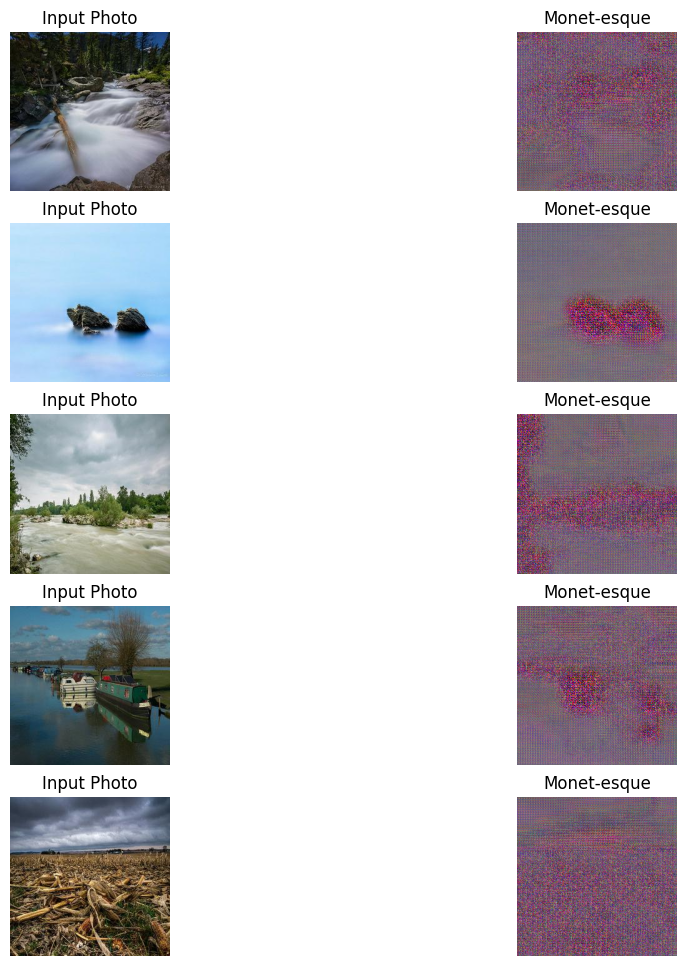

In [ ]:
import torchvision.io as io
from torchvision.io import ImageReadMode

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(PHOTO_FILENAMES[:5]):
    with torch.no_grad():
        img = io.read_image(img, mode=ImageReadMode.RGB)
        prediction = model.monet_gen(img.unsqueeze(0).float()).squeeze(0)
        prediction = prediction.permute(1,2,0)
        prediction = (prediction * 127.5 + 127.5)
        # normalized = (prediction - prediction.min()) / (prediction.max() - prediction.min())
        # prediction = normalized * 255
        prediction = prediction.numpy().astype(np.uint8)
        # prediction = PIL.Image.fromarray(prediction)
        img = (img.permute(1,2, 0)).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
! mkdir /content/images

mkdir: cannot create directory ‘/content/images’: File exists


In [ ]:
!rm -rf /content/images/*

In [ ]:
i = 1
for img in PHOTO_FILENAMES:
    with torch.no_grad():
        img = io.read_image(img, mode=ImageReadMode.RGB)
        prediction = model.photo_gen(img.unsqueeze(0).float())[0].numpy()
        prediction = prediction.transpose(1,2,0)
        normalized = (prediction - prediction.min()) / (prediction.max() - prediction.min())
        prediction = normalized * 255
        prediction = prediction.astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/content/images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/content/images", 'zip', "/content/images/")

'/content/images.zip'

## Discussion and Conclusion



In [ ]:
https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/basic-gan.html
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/tree/master